In [181]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import operator

## data

In [320]:
def produce_data(filename):
    file = open(filename)
    sentences = []
    pos = []
    labels = []
    sentence, sentence_pos, sentence_labels = [], [], []
    
    for entry in file:
        if len(entry.split(' ')) == 1:
            sentences.append(sentence)
            labels.append(sentence_labels)
            pos.append(sentence_pos)
            sentence, sentence_pos, sentence_labels = [], [], []
        else:
            word, word_pos, word_label = entry.split(' ')
            sentence.append(word.lower())
            sentence_pos.append(word_pos)
            sentence_labels.append(word_label[0])
    file.close()
    return sentences, pos, labels

def produce_onehot(sentences, word_lst=None):
    if word_lst is None:
        word_lst = get_word_lst(sentences)
    
    num_words = len(word_lst) + 1
    
    vectors, sentence_vectors = [], []
    for sentence in sentences:
        sentence_vectors = []
        for word in sentence:
            vector = np.zeros((num_words))
            if word in word_lst:
                vector[word_lst.index(word)] = 1.
            else:
                vector[-1] = 1.
            sentence_vectors.append(vector)
            
        vectors.append(sentence_vectors)
    return vectors, word_lst

def find_in_list(lst, elem):
    if elem in lst:
        return(lst.index(elem))
    return 0

def process_pos(pos, pos_set=None):
    if pos_set is None:
        pos_set = list(set([elem for sentence in pos for elem in sentence]))
        pos_set = ["Unknown"] + pos_set
    pos_indexed = [[find_in_list(pos_set, elem) for elem in sentence] for sentence in pos]
    pos_onehot = []
    for sentence in pos_indexed:
        sentence_onehot = []
        for word in sentence:
            word_onehot = np.zeros((len(pos_set)))
            word_onehot[word] = 1.
            sentence_onehot.append(word_onehot)
        pos_onehot.append(sentence_onehot)
    return pos_onehot, pos_set

def process_labels(labels):
    new_labels = []
    for sentence in labels:
        sentence_labels = []
        for word in sentence:
            if word == 'B':
                word_label = 0
            if word == 'I':
                word_label = 1
            if word == 'O':
                word_label = 2
            sentence_labels.append(word_label)
        sentence_labels = np.array(sentence_labels)
        new_labels.append(sentence_labels)
    return new_labels

def concat_features(vectors, one_hot):
    new_features = []
    for v_sentence, p_sentence in list(zip(vectors, one_hot)):
        sentence_features = []
        for v_word, p_word in list(zip(v_sentence, p_sentence)):
#             print(p_word.shape)
#             print(v_word.shape)
            word_features = np.concatenate([v_word, p_word])[None, :]
            sentence_features.append(word_features)
        sentence_features = np.concatenate(sentence_features)
        new_features.append(sentence_features)
    return new_features

def get_word_lst(sentences):
    word_lst = []
    for sentence in sentences:
        for word in sentence:
            word_lst.append(word)
    word_lst = list(set(word_lst))
    return word_lst
    
def get_word_lst_file(filename, n_sentesnces):
    sentences, _, _ = produce_data(filename)
    sentences = sentences[:n_sentesnces]
    return get_word_lst(sentences)

In [321]:
def prepare_data(filename, pos_set=None, word_lst=None):
    sentences, pos, labels = produce_data(filename)
    vectors, word_lst = produce_onehot(sentences, word_lst)
    pos_onehot, pos_set = process_pos(pos, pos_set)
    indexed_labels = process_labels(labels)
#     return pos_onehot
    features = concat_features(vectors, pos_onehot)
    return features, indexed_labels, pos_set, word_lst

In [322]:
words = get_word_lst_file('test.txt', 500)
x_te, y_te, _, _ = prepare_data('test.txt', word_lst=words)

In [185]:
def pad(x, y):
    maxlen = np.max([seq.shape[0] for seq in x])
    D = x[0].shape[1]
    padded_x = []
    padded_y = []
    seq_lens = []
    for seq, labels in list(zip(x, y)):
        seq_len = seq.shape[0]
        padded_seq = np.concatenate([seq, np.zeros((maxlen - seq_len, D))])[None, :, :]
        padded_labels = np.concatenate([labels, np.zeros((maxlen - seq_len))])[None, :]
        padded_x.append(padded_seq)
        padded_y.append(padded_labels)
        seq_lens.append(seq_len)
    return np.concatenate(padded_x), np.concatenate(padded_y), np.array(seq_lens)

In [193]:
def tosymbol(num):
    return {0: 'B', 1: 'I', 2: 'O'}[num]

def make_classification_data(x, y):
    x_new, y_new = [], []
    for seq, labels in list(zip(x, y)):
        x_new.append(seq)
        y_new.append(labels)
    x_new = np.concatenate(x_new)
    y_new = np.concatenate(y_new)
    y_new[y_new == 1] = 0
    y_new[y_new == 2] = 1
    return x_new, y_new

### Classification data

In [326]:
def get_word_dict(sentences):
    word_dict = defaultdict(int)
    for sentence in sentences:
        for word in sentence:
            word_dict[word] += 1
    return word_dict
    
def get_word_dict_file(filename, n_sentesnces):
    sentences, _, _ = produce_data(filename)
    sentences = sentences[:n_sentesnces]
    return get_word_dict(sentences)

In [358]:
words = get_word_dict_file('test.txt', 500)

In [359]:
words = sorted(words.items(), key=operator.itemgetter(1))

In [360]:
words = [word[0] for word in words if word[1] > 3]

In [361]:
len(words)

442

In [386]:
# x_tr, y_tr, pos_set = prepare_data('train.txt', model)
# words = get_word_lst_file('test.txt', 500)
x_te, y_te, pos_set, word_lst = prepare_data('test.txt', word_lst=words)
x_tr, y_tr = x_te[:500], y_te[:500]
x_te, y_te = x_te[500:], y_te[500:]

In [387]:
x_te, y_te = make_classification_data(x_te, y_te)
x_tr, y_tr = make_classification_data(x_tr, y_tr)

In [388]:
np.save('data_class/x_tr', x_tr[:, -43:])
np.save('data_class/x_te', x_te[:, -43:])
np.save('data_class/y_tr', y_tr)
np.save('data_class/y_te', y_te)

### Structured Prediction data

In [444]:
# x_tr, y_tr, pos_set = prepare_data('train.txt', model)
# words = get_word_lst_file('test.txt', 500)
x_te, y_te, _, _ = prepare_data('test.txt', word_lst=words)
x_tr, y_tr = x_te[:500], y_te[:500]
x_te, y_te = x_te[500:], y_te[500:]

In [445]:
x_te, y_te, seq_lens_te = pad(x_te, y_te)
x_tr, y_tr, seq_lens_tr = pad(x_tr, y_tr)

In [446]:
x_te = x_te[:, :, -43:]
x_tr = x_tr[:, :, -43:]

## Pretrained embedding

In [447]:
P = np.load('P.npy')
d, D = P.shape

In [448]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [449]:
x_tr_flat = x_tr_flat.dot(P.T)
x_te_flat = x_te_flat.dot(P.T)

In [450]:
x_tr = x_tr_flat.reshape(list(x_tr.shape[:2])+[d])
x_te = x_te_flat.reshape(list(x_te.shape[:2])+[d])

## Training

In [400]:
import numpy as np
import tensorflow as tf
import t3f
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from TTGP.gpstruct import TTGPstruct
from TTGP import grid
from TTGP.covariance import SE_multidim, BinaryKernel
from TTGP.projectors import LinearProjector, Identity
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [451]:
D = x_tr.shape[-1]
# d = 3
n_labels = 3

In [452]:
x_tr_flat = x_tr.reshape([-1, D])
x_te_flat = x_te.reshape([-1, D])

In [453]:
scaler = StandardScaler()
x_tr_flat = scaler.fit_transform(x_tr_flat)/3
x_te_flat = scaler.transform(x_te_flat)/3

In [454]:
x_tr = x_tr_flat.reshape(x_tr.shape)
x_te = x_te_flat.reshape(x_te.shape)

In [455]:
x_tr[x_tr > 1] = 1
x_tr[x_tr < -1] = -1
x_te[x_te > 1] = 1
x_te[x_te < -1] = -1

### GP

In [456]:
tf.reset_default_graph()

In [457]:
num = 10
inputs = grid.InputsGrid(d, left=-1., right=1., npoints=num)
projector = Identity(D)#LinearProjector(d=d, D=D)
cov = SE_multidim(n_labels, .7, .3, .1, projector)
bin_cov = BinaryKernel(n_labels, alpha=1.)

In [458]:
mu_ranks = 10
gp = TTGPstruct(cov, bin_cov, inputs, mu_ranks)

In [459]:
x_tr_ = tf.constant(x_tr)[:150]
x_te_ = tf.constant(x_te)
y_tr_ = tf.constant(y_tr)[:150]
y_te_ = tf.constant(y_te)
seq_lens_tr_ = tf.constant(seq_lens_tr)[:150]
seq_lens_te_ = tf.constant(seq_lens_te)

In [460]:
N = x_tr.shape[0]
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(1e-2, global_step, 
                                        100, 0.5, staircase=True)

In [461]:
elbo_op, train_op = gp.fit(x_tr_, y_tr_, seq_lens_tr_, N, lr, global_step)

_latent_vars_distribution/x_flat (?, 4) = sum_len x 4
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov (3, 150, 63, 63) = [3, 150, 63, 63]
_Knns/K_nn (3, 150, 63, 63) = 3 x 150 x 63 x 63
_sample_f/f_un (3, 150, 63) = 3 150 63
_sample_f/f_bin (9,) = 9


### Learning

In [462]:
sess = tf.Session()
gp.initialize(sess)
sess.run(tf.global_variables_initializer())
elbo_vals = []

In [ ]:
def eval_method(y, y_pred):
    sum = 0
    sum_len = 0
    confusion_mat = np.zeros((3, 3))
    for y, pred in list(zip(y, y_pred)):
        confusion_mat += confusion_matrix(y[:len(pred)], np.array(pred), labels=[0, 1, 2])
        sum += np.sum(y[:len(pred)] == np.array(pred))
        sum_len += len(pred)
    return sum / sum_len, confusion_mat

In [ ]:
maxiter = 500
eval_freq = 20

for i in range(maxiter):
    _, elbo = sess.run([train_op, elbo_op])
    print(i, elbo)
    elbo_vals.append(elbo)
    if not i%eval_freq:
        preds = gp.predict(x_te_, seq_lens_te_, sess)
        acc, conf = eval_method(y_te, preds)
        print('accuracy:', acc)

0 106.66256078
_latent_vars_distribution/x_flat (?, 4) = sum_len x 4
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov (3, 323, 63, 63) = [3, 323, 63, 63]
_Knns/K_nn (3, 323, 63, 63) = 3 x 323 x 63 x 63
accuracy: 0.579912775782
1 99.7785984581
2 105.568629741
3 99.4303788303
4 118.471852451
5 100.829629966
6 106.100821721
7 120.497098574
8 82.3556674405
9 107.938501944
10 111.417779813
11 75.8981637913
12 100.871310379
13 95.8816162064
14 79.1969624827
15 102.765613866
16 91.4868455199
17 74.4281773635
18 86.6347660266
19 85.9956305808
20 79.7459536229
_latent_vars_distribution/x_flat (?, 4) = sum_len x 4
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov

In [260]:
sess.close()

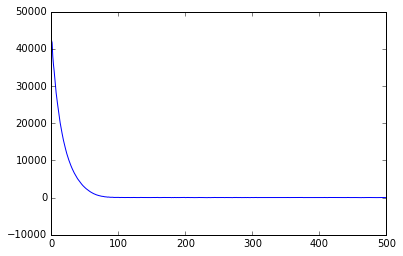

In [415]:
plt.plot(elbo_vals)

Prediction

In [416]:
preds = gp.predict(x_te_, seq_lens_te_, sess)

_latent_vars_distribution/x_flat (?, 3) = sum_len x 3
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov (3, 323, 63, 63) = [3, 323, 63, 63]
_Knns/K_nn (3, 323, 63, 63) = 3 x 323 x 63 x 63


In [426]:
sentences_te, _, _ = produce_data('test.txt')
sentences_te = sentences_te[500:]

In [439]:
i = 5
y_te[i, :seq_lens_te[i]] == preds[i]
# print(y_te[i])

print('y   pred')
print()
for word, label, pred in list(zip(sentences_te[i], y_te[i].tolist(), preds[i])):
    if label == pred:
        print(tosymbol(int(label)), '\t', word)
    else:
        print(tosymbol(int(label)), '≠', tosymbol(pred), '\t', word)

y   pred

O 	 in
B 	 recent
I 	 weeks
B ≠ I 	 mr.
I 	 merksamer
O 	 has
O 	 approached
B 	 a
I 	 number
O 	 of
B 	 his
I 	 suppliers
O 	 and
O 	 asked
B 	 them
O 	 to
O 	 provide
B 	 letters
O 	 of
B 	 intent
O 	 saying
B 	 they
O 	 will
O 	 continue
O 	 shipping
B 	 merchandise
O 	 to
B 	 the
I 	 chain
O 	 following
B 	 the
I 	 buy-out
O 	 ,
O 	 say
B 	 those
O ≠ I 	 familiar
O 	 with
B 	 the
I 	 situation
O 	 .


In [249]:
for pred in preds:
    if pred[0] == 1:
        pred[0] = 0

0.914828116983


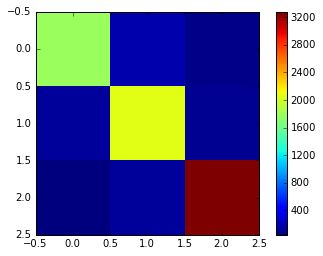

In [420]:
acc, conf = eval_method(y_te, preds)
print(acc)
plt.imshow(conf, interpolation="Nearest")
plt.colorbar()

In [419]:
(np.sum(confusion_mat[:2, :2]) + confusion_mat[2, 2]) / np.sum(confusion_mat)

0.95100051308363265

In [422]:
m_bin = sess.run(gp.bin_mu)

In [423]:
for i in range(3):
    for j in range(3):
        print(m_bin[3 * i + j], tosymbol(i), tosymbol(j))

-0.692548472487 B B
0.982015259619 B I
-0.280595302583 B O
-0.862177120278 I B
0.529287318787 I I
-0.0127605323258 I O
1.03122352756 O B
-1.23564619949 O I
0.704968294317 O O


In [320]:
sess.run(gp.bin_cov.alpha)

4.9847481144547272

In [926]:
sigma_bin_l.shape

(9, 9)

In [ ]:
sigma_bin = sigma_bin_l

In [727]:
y == np.array(pred)

False

In [724]:
pred

[1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2]

In [ ]:
y_te

In [716]:
len(preds[0])

28

In [710]:
np.sum(y_te == preds) / preds.size

0.0

In [614]:
m_un, S_un, m_bin, S_bin = gp._latent_vars_distribution(x_tr_, seq_lens_tr_)

_latent_vars_distribution/x_flat (?, 339) = sum_len x 339
_latent_vars_distribution/m_un_flat <unknown> = sum_len x 3
cov_for_squared_dists/cov (3, 77, 50, 50) = [3, 77, 50, 50]
_Knns/K_nn (3, 77, 50, 50) = 3 x 77 x 50 x 50


In [611]:

y_te

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  2., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.]])

In [615]:
S_un_ = sess.run(S_un)

In [622]:
S_un_[0, 0, 24, 24]

0.4705951739073676

In [621]:
S_un_[0, 0, 24, 7]

0.4705951739073676

In [665]:
def _compute_chol(seq_lens, cov_mat):

    n_labels, batch_size, max_len, _ = cov_mat.get_shape().as_list()
    sequence_mask = tf.logical_not(tf.sequence_mask(seq_lens, maxlen=max_len))
    sequence_mask = tf.cast(sequence_mask, tf.float64)
    I = tf.eye(max_len, batch_shape=[n_labels, batch_size], dtype=tf.float64)
     # We add ones on diagonals in the meaningless dimensions of covs.
    new_cov_mat = cov_mat + tf.einsum('lsij,si->lsij', I, sequence_mask)
 
         # NOTE: if same word (x) is repeated the matrix becomes singular
         # ugly solution
    new_cov_mat = new_cov_mat + 0.1 * I
 
    return new_cov_mat

In [666]:
ans = sess.run(_compute_chol(seq_lens_tr_, S_un))

In [667]:
np.linalg.det(ans[0, 56])

-7.8457487274626774e-15

In [682]:
np.linalg.det(S_un_[0, 56] +0.5 * np.eye(50))

0.15925627839341569

In [672]:
sess.run(gp.cov.l)

array([ 0.301,  0.301,  0.301])

In [685]:
ans_ = ans[0, 56]
ans_[ans_ < 0] = 0

In [671]:
sess.run(gp.cov.sigma_f)

array([ 0.728,  0.728,  0.728])

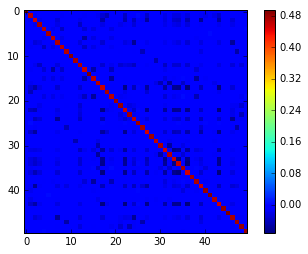

In [668]:
plt.imshow(S_un_[0, 56], interpolation="nearest")
plt.colorbar()

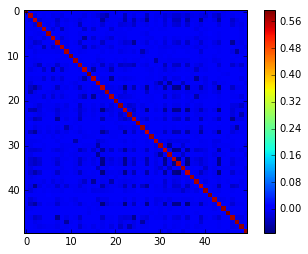

In [655]:
plt.imshow(ans[0, 56], interpolation="nearest")
plt.colorbar()

In [630]:
np.linalg.cholesky(S_un_[0, 0, :37, :37] + np.eye(37) * 0.1)

array([[  7.660e-01,   0.000e+00,   0.000e+00, ...,   0.000e+00,
          0.000e+00,   0.000e+00],
       [ -6.851e-06,   7.553e-01,   0.000e+00, ...,   0.000e+00,
          0.000e+00,   0.000e+00],
       [  7.551e-05,  -1.388e-02,   7.460e-01, ...,   0.000e+00,
          0.000e+00,   0.000e+00],
       ..., 
       [ -7.580e-05,  -1.427e-02,  -3.549e-02, ...,   7.206e-01,
          0.000e+00,   0.000e+00],
       [ -1.254e-05,  -1.238e-02,   3.159e-04, ...,   3.770e-03,
          7.527e-01,   0.000e+00],
       [  3.977e-06,  -1.349e-02,  -4.332e-02, ...,  -1.477e-01,
          3.389e-03,   7.001e-01]])

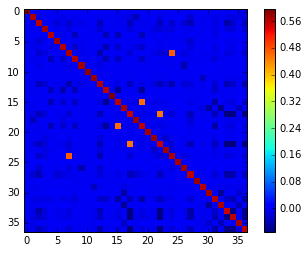

In [629]:
plt.imshow(S_un_[0, 0, :37, :37] + np.eye(37) * 0.1, interpolation="nearest")
plt.colorbar()

In [618]:
np.linalg.cholesky(S_un_[0, 0, :37, :37])

LinAlgError: Matrix is not positive definite

In [595]:
sess.close()